# 02 — EDA on Raw Data

**Goal:** Understand the raw data before any cleaning. Distributions, missing values, outliers, target variable analysis.

**Inputs:** `../data/raw/*.csv`

**Outputs:** Plots saved to `../figures/`

**Next:** `03_cleaning_merging.ipynb`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 100

RAW_PATH     = '../data/raw/'
FIGURES_PATH = '../figures/'
os.makedirs(FIGURES_PATH, exist_ok=True)

In [2]:
# Load the 7 files relevant for modelling
players     = pd.read_csv(RAW_PATH + 'players.csv',           low_memory=False)
appearances = pd.read_csv(RAW_PATH + 'appearances.csv',       low_memory=False)
valuations  = pd.read_csv(RAW_PATH + 'player_valuations.csv', low_memory=False)
club_games  = pd.read_csv(RAW_PATH + 'club_games.csv',        low_memory=False)
lineups     = pd.read_csv(RAW_PATH + 'game_lineups.csv',      low_memory=False)
clubs       = pd.read_csv(RAW_PATH + 'clubs.csv',             low_memory=False)
transfers   = pd.read_csv(RAW_PATH + 'transfers.csv',         low_memory=False)

valuations['date']          = pd.to_datetime(valuations['date'])
appearances['date']         = pd.to_datetime(appearances['date'])
players['date_of_birth']    = pd.to_datetime(players['date_of_birth'])
transfers['transfer_date']  = pd.to_datetime(transfers['transfer_date'], errors='coerce')

print('Loaded all files.')
print(f'  clubs:     {len(clubs):,} rows,  {clubs.shape[1]} columns')
print(f'  transfers: {len(transfers):,} rows, {transfers.shape[1]} columns')

Loaded all files.
  clubs:     451 rows,  17 columns
  transfers: 85,293 rows, 10 columns


## 1. Missing Values Overview

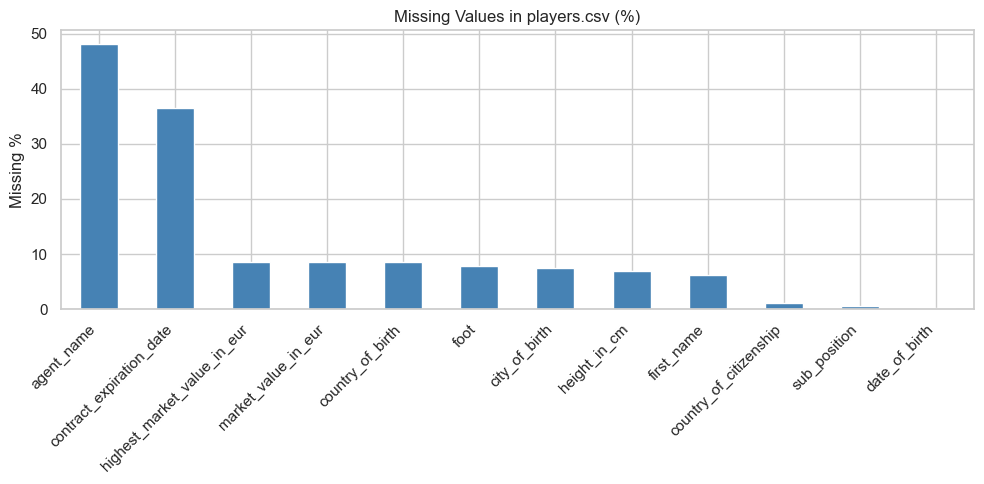

agent_name                     48.170074
contract_expiration_date       36.443965
highest_market_value_in_eur     8.503689
market_value_in_eur             8.503689
country_of_birth                8.503689
foot                            7.765886
city_of_birth                   7.550086
height_in_cm                    6.981424
first_name                      6.234872
country_of_citizenship          1.035257
sub_position                    0.551165
date_of_birth                   0.142895


In [3]:
# Missing values in players.csv — the most important file
missing = (players.isnull().sum() / len(players) * 100).sort_values(ascending=False)
missing = missing[missing > 0]

fig, ax = plt.subplots(figsize=(10, 5))
missing.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Missing Values in players.csv (%)')
ax.set_ylabel('Missing %')
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_missing_players.png')
plt.show()
print(missing.to_string())

## 2. Target Variable — Market Value Distribution

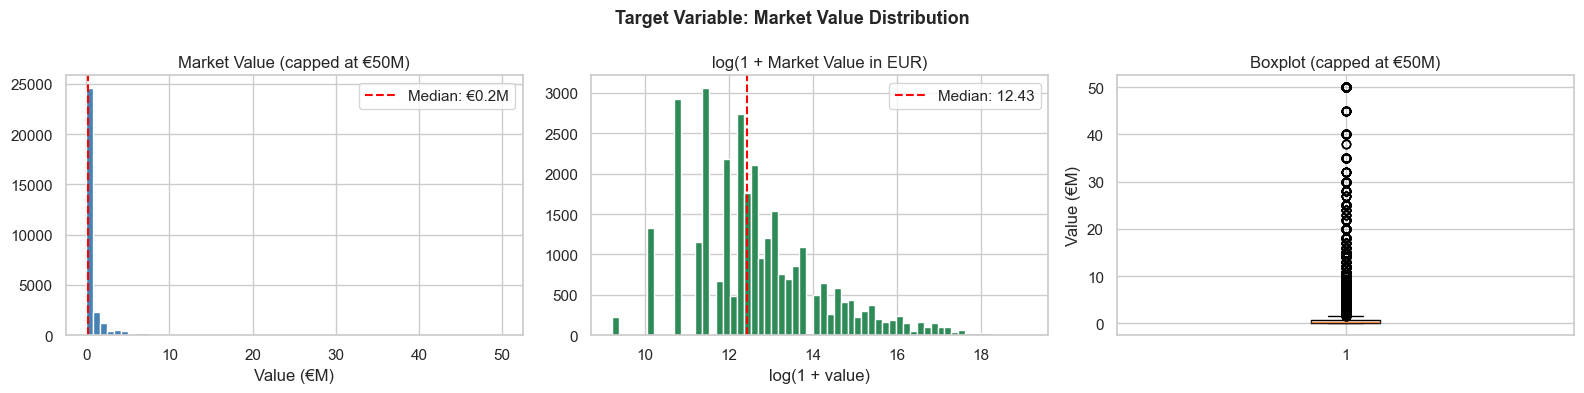

Count:    31,375
Mean:     €1.66M
Median:   €0.25M
Std:      €6.46M
Skewness: 10.98
Max:      €200.0M


In [5]:
# Use latest valuation per player
latest_vals = valuations.sort_values('date').groupby('player_id').last().reset_index()
mv = latest_vals['market_value_in_eur'].dropna()
mv_m = mv / 1_000_000

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Raw distribution (capped at 50M for readability)
axes[0].hist(mv_m.clip(upper=50), bins=60, color='steelblue', edgecolor='white')
axes[0].set_title('Market Value (capped at €50M)')
axes[0].set_xlabel('Value (€M)')
axes[0].axvline(mv_m.median(), color='red', linestyle='--', label=f'Median: €{mv_m.median():.1f}M')
axes[0].legend()

# Log distribution
log_mv = np.log1p(mv)
axes[1].hist(log_mv, bins=60, color='seagreen', edgecolor='white')
axes[1].set_title('log(1 + Market Value in EUR)')
axes[1].set_xlabel('log(1 + value)')
axes[1].axvline(log_mv.median(), color='red', linestyle='--', label=f'Median: {log_mv.median():.2f}')
axes[1].legend()

# Boxplot
axes[2].boxplot(mv_m.clip(upper=50), vert=True)
axes[2].set_title('Boxplot (capped at €50M)')
axes[2].set_ylabel('Value (€M)')

plt.suptitle('Target Variable: Market Value Distribution', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_target_distribution.png')
plt.show()

print(f'Count:    {len(mv_m):,}')
print(f'Mean:     €{mv_m.mean():.2f}M')
print(f'Median:   €{mv_m.median():.2f}M')
print(f'Std:      €{mv_m.std():.2f}M')
print(f'Skewness: {mv_m.skew():.2f}')
print(f'Max:      €{mv_m.max():.1f}M')

## 3. Players — Demographics

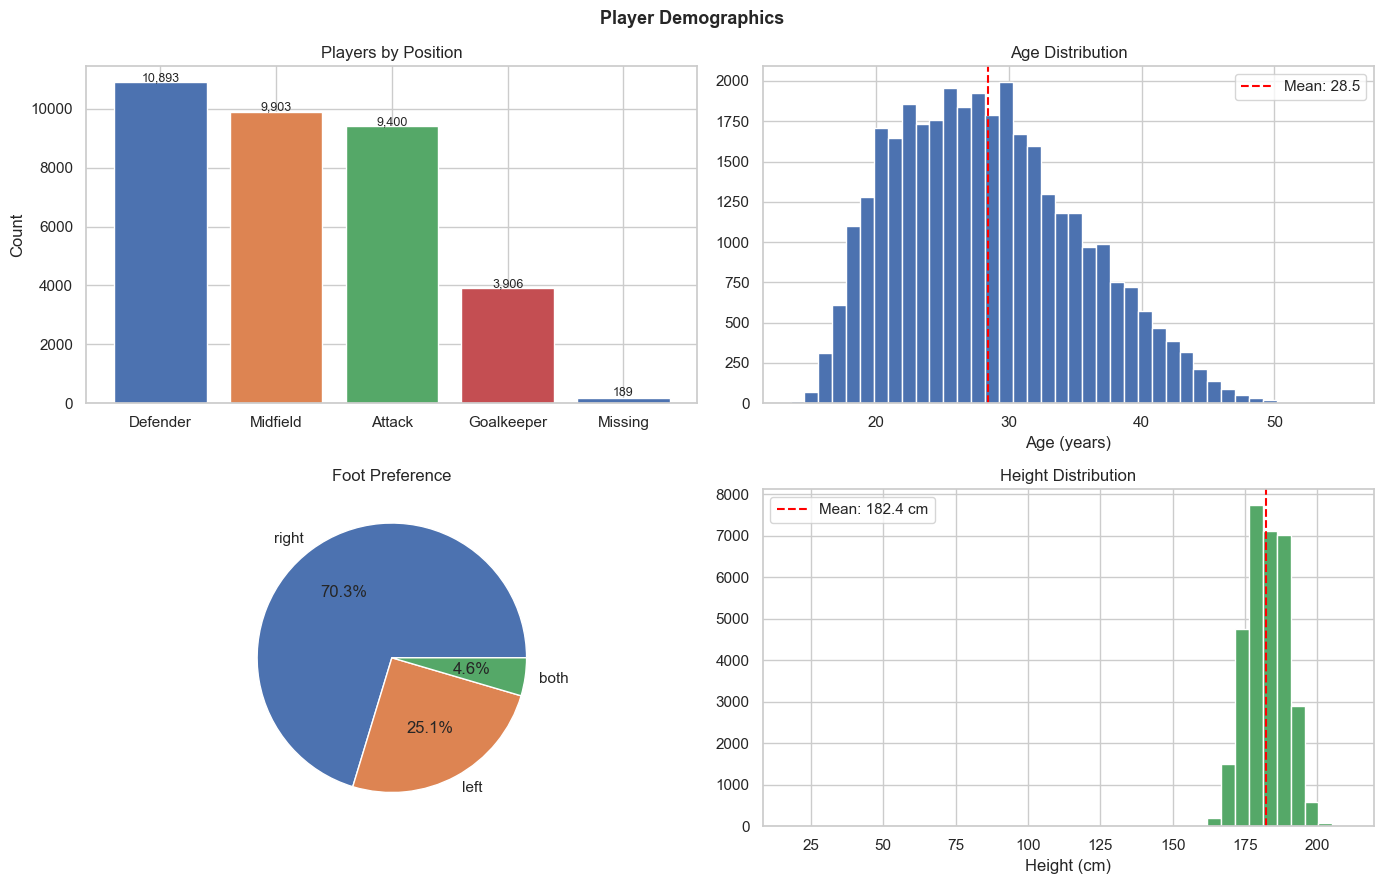

In [6]:
# Compute age from date_of_birth
today = pd.Timestamp('2024-01-01')
players['age'] = ((today - players['date_of_birth']).dt.days / 365.25).round(1)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Position distribution
pos_counts = players['position'].value_counts()
axes[0, 0].bar(pos_counts.index, pos_counts.values, color=['#4C72B0','#DD8452','#55A868','#C44E52'])
axes[0, 0].set_title('Players by Position')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(pos_counts.values):
    axes[0, 0].text(i, v + 50, f'{v:,}', ha='center', fontsize=9)

# Age distribution
age_data = players['age'].dropna()
axes[0, 1].hist(age_data, bins=40, color='#4C72B0', edgecolor='white')
axes[0, 1].set_title('Age Distribution')
axes[0, 1].set_xlabel('Age (years)')
axes[0, 1].axvline(age_data.mean(), color='red', linestyle='--', label=f'Mean: {age_data.mean():.1f}')
axes[0, 1].legend()

# Foot preference
foot_counts = players['foot'].value_counts()
axes[1, 0].pie(foot_counts.values, labels=foot_counts.index, autopct='%1.1f%%',
               colors=['#4C72B0','#DD8452','#55A868'])
axes[1, 0].set_title('Foot Preference')

# Height distribution
height_data = players['height_in_cm'].dropna()
axes[1, 1].hist(height_data, bins=40, color='#55A868', edgecolor='white')
axes[1, 1].set_title('Height Distribution')
axes[1, 1].set_xlabel('Height (cm)')
axes[1, 1].axvline(height_data.mean(), color='red', linestyle='--', label=f'Mean: {height_data.mean():.1f} cm')
axes[1, 1].legend()

plt.suptitle('Player Demographics', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_player_demographics.png')
plt.show()

## 4. Appearances — Performance Stats

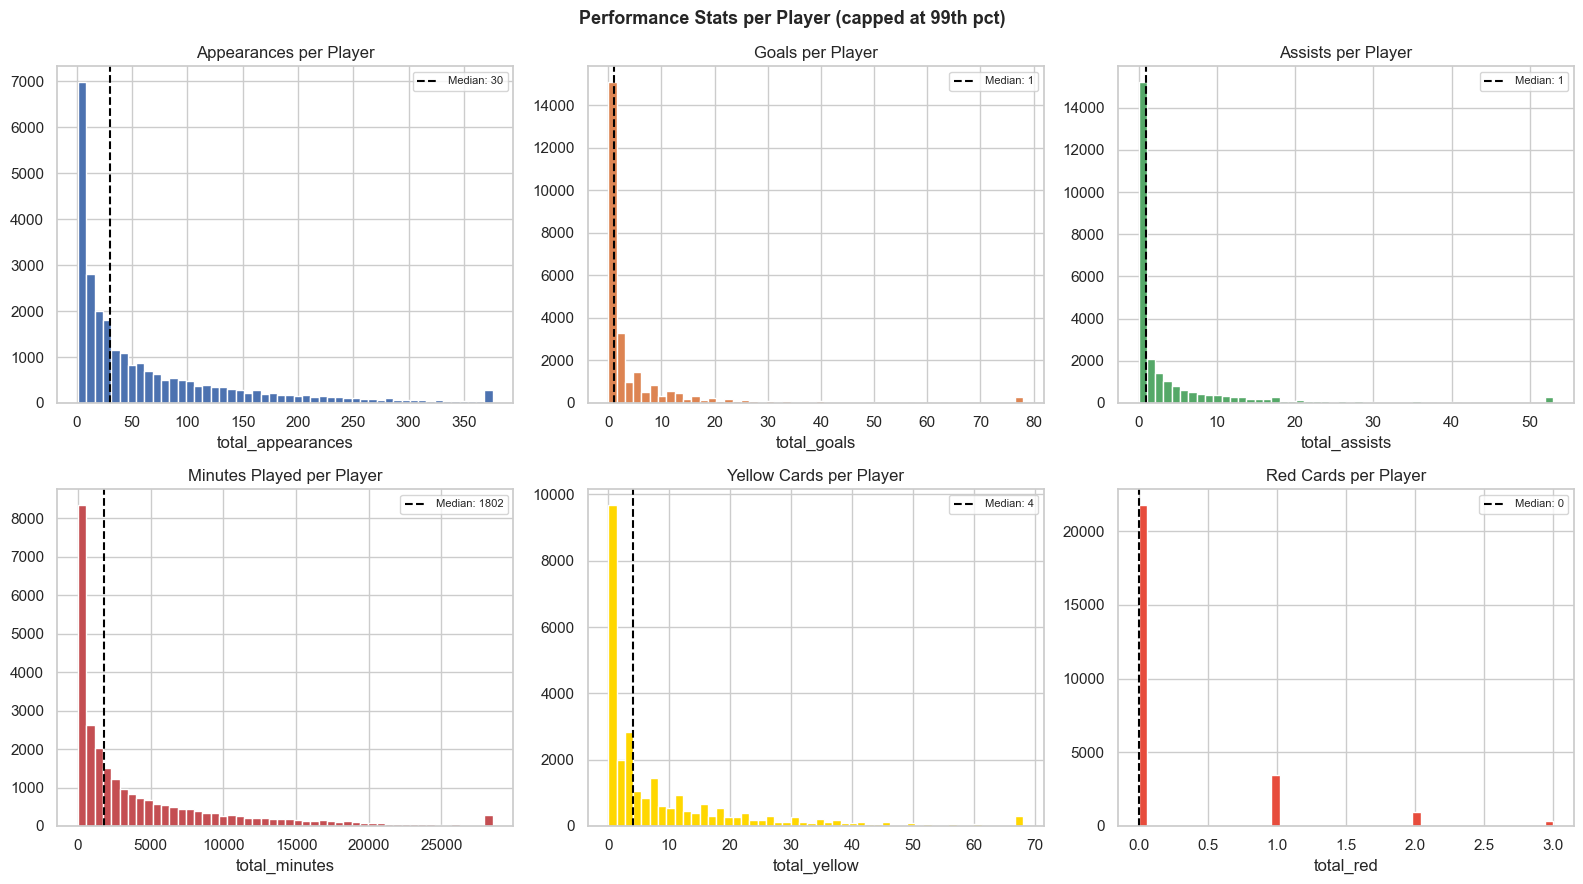

In [7]:
# Aggregate per player
agg = appearances.groupby('player_id').agg(
    total_appearances=('appearance_id', 'count'),
    total_goals=('goals', 'sum'),
    total_assists=('assists', 'sum'),
    total_minutes=('minutes_played', 'sum'),
    total_yellow=('yellow_cards', 'sum'),
    total_red=('red_cards', 'sum'),
).reset_index()

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

cols = ['total_appearances', 'total_goals', 'total_assists',
        'total_minutes', 'total_yellow', 'total_red']
titles = ['Appearances per Player', 'Goals per Player', 'Assists per Player',
          'Minutes Played per Player', 'Yellow Cards per Player', 'Red Cards per Player']
colors = ['#4C72B0','#DD8452','#55A868','#C44E52','#FFD700','#E74C3C']

for ax, col, title, color in zip(axes, cols, titles, colors):
    data_plot = agg[col].clip(upper=agg[col].quantile(0.99))
    ax.hist(data_plot, bins=50, color=color, edgecolor='white')
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.axvline(agg[col].median(), color='black', linestyle='--',
               label=f'Median: {agg[col].median():.0f}')
    ax.legend(fontsize=8)

plt.suptitle('Performance Stats per Player (capped at 99th pct)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_performance_distributions.png')
plt.show()

## 5. Valuations Over Time

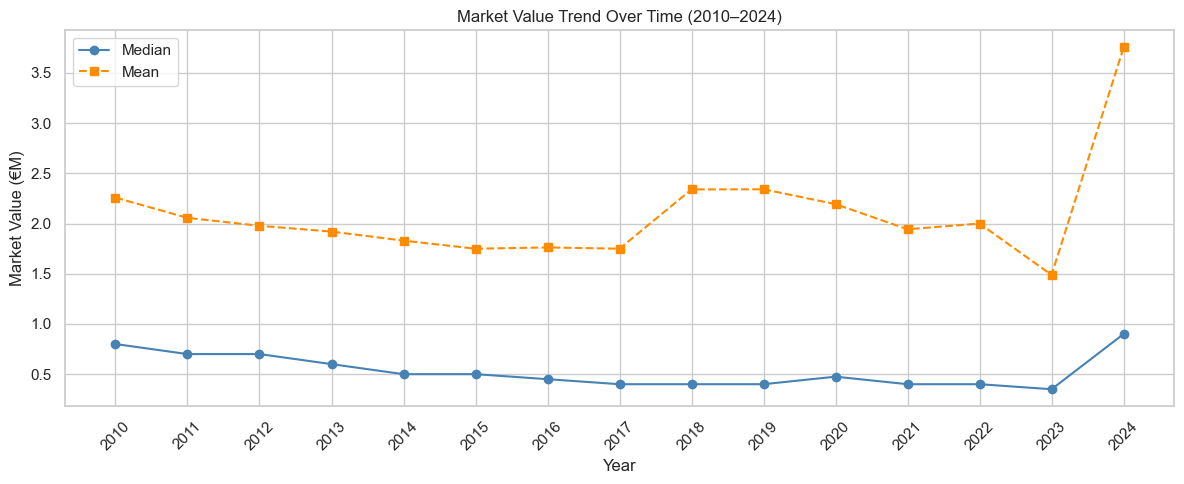

In [8]:
valuations['year'] = valuations['date'].dt.year
yearly = valuations.groupby('year')['market_value_in_eur'].agg(['median','mean']).reset_index()
yearly = yearly[(yearly['year'] >= 2010) & (yearly['year'] <= 2024)]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(yearly['year'], yearly['median'] / 1e6, marker='o', label='Median', color='steelblue')
ax.plot(yearly['year'], yearly['mean'] / 1e6, marker='s', linestyle='--', label='Mean', color='darkorange')
ax.set_title('Market Value Trend Over Time (2010–2024)')
ax.set_xlabel('Year')
ax.set_ylabel('Market Value (€M)')
ax.legend()
ax.set_xticks(yearly['year'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_valuations_over_time.png')
plt.show()

## 6. Market Value by Position

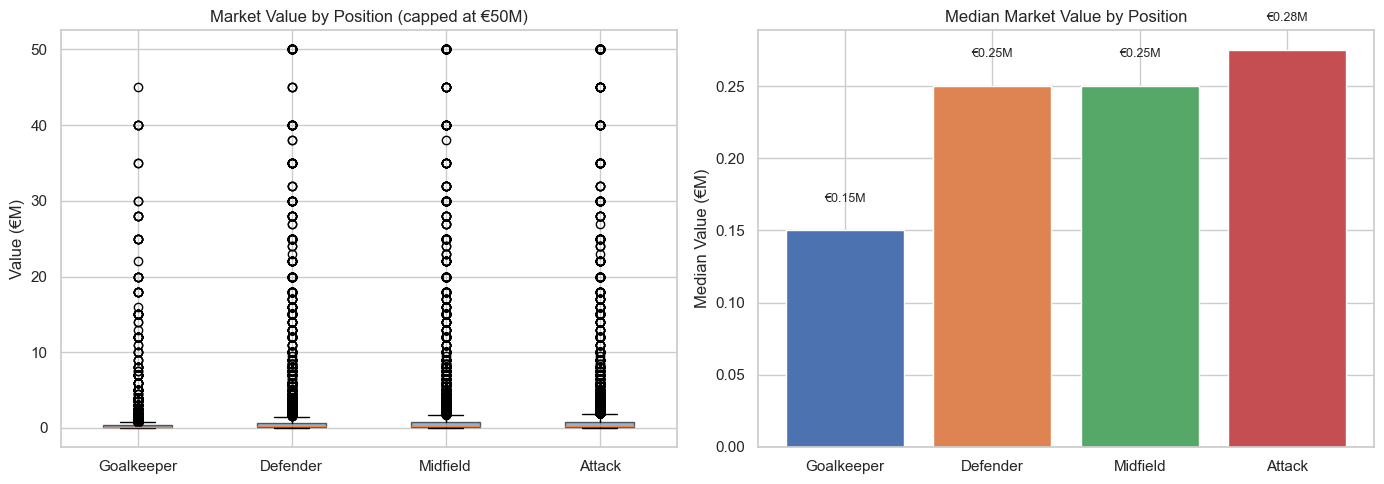

In [9]:
# Merge latest valuation with position
merged = latest_vals.merge(players[['player_id', 'position']], on='player_id', how='inner')
merged['market_value_m'] = merged['market_value_in_eur'] / 1e6

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot by position
order = ['Goalkeeper', 'Defender', 'Midfield', 'Attack']
data_pos = [merged[merged['position'] == p]['market_value_m'].clip(upper=50) for p in order]
axes[0].boxplot(data_pos, labels=order, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.6))
axes[0].set_title('Market Value by Position (capped at €50M)')
axes[0].set_ylabel('Value (€M)')

# Median value by position
medians = merged.groupby('position')['market_value_m'].median().reindex(order)
axes[1].bar(order, medians.values, color=['#4C72B0','#DD8452','#55A868','#C44E52'])
axes[1].set_title('Median Market Value by Position')
axes[1].set_ylabel('Median Value (€M)')
for i, v in enumerate(medians.values):
    axes[1].text(i, v + 0.02, f'€{v:.2f}M', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_value_by_position.png')
plt.show()

## 7. Correlation — Numeric Features vs Market Value

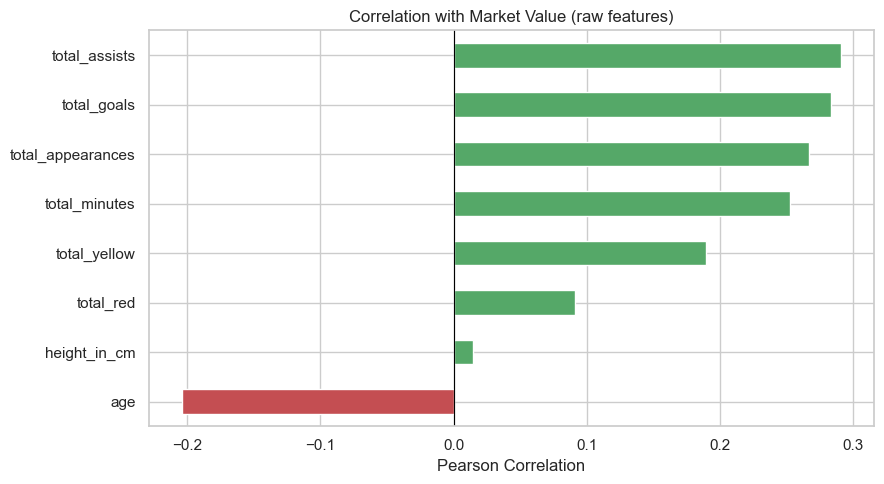

age                 -0.204072
height_in_cm         0.014363
total_red            0.091383
total_yellow         0.189611
total_minutes        0.252805
total_appearances    0.267224
total_goals          0.283749
total_assists        0.291189


In [10]:
# Build a flat table: player + agg stats + latest value
combined = latest_vals[['player_id', 'market_value_in_eur']].merge(
    players[['player_id', 'age', 'height_in_cm']], on='player_id', how='inner'
).merge(agg, on='player_id', how='inner')

numeric_cols = ['age', 'height_in_cm', 'total_appearances', 'total_goals',
                'total_assists', 'total_minutes', 'total_yellow', 'total_red']

corr_target = combined[numeric_cols + ['market_value_in_eur']].corr()['market_value_in_eur'].drop('market_value_in_eur').sort_values()

fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#C44E52' if v < 0 else '#55A868' for v in corr_target.values]
corr_target.plot(kind='barh', ax=ax, color=colors)
ax.set_title('Correlation with Market Value (raw features)')
ax.set_xlabel('Pearson Correlation')
ax.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_correlations.png')
plt.show()
print(corr_target.to_string())

## 8. Outlier Check — Key Features

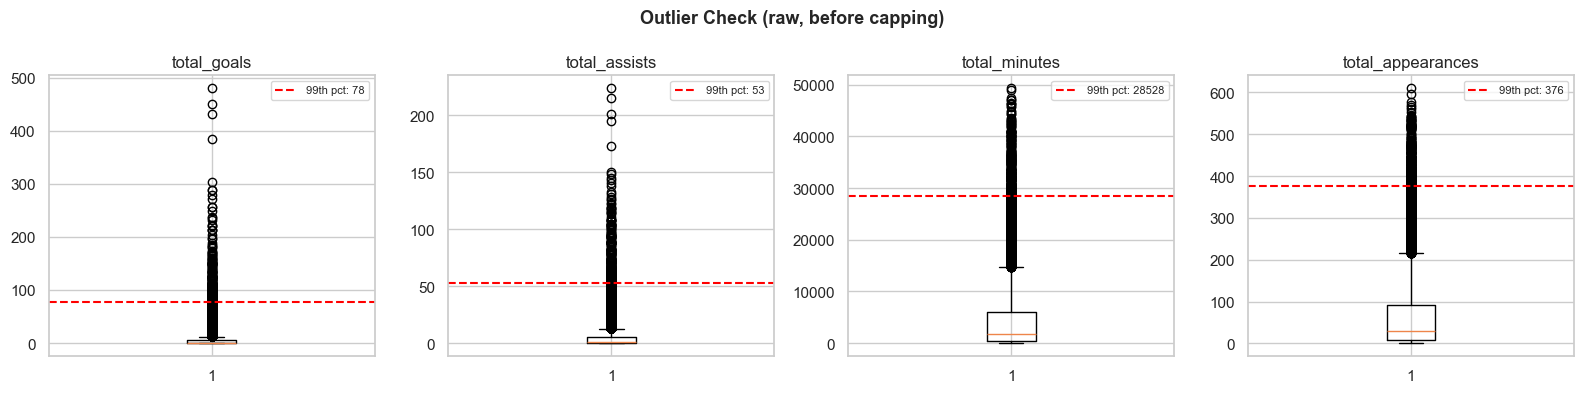

In [11]:
check_cols = ['total_goals', 'total_assists', 'total_minutes', 'total_appearances']

fig, axes = plt.subplots(1, len(check_cols), figsize=(16, 4))
for ax, col in zip(axes, check_cols):
    ax.boxplot(agg[col].dropna(), vert=True)
    p99 = agg[col].quantile(0.99)
    ax.axhline(p99, color='red', linestyle='--', label=f'99th pct: {p99:.0f}')
    ax.set_title(col)
    ax.legend(fontsize=8)

plt.suptitle('Outlier Check (raw, before capping)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_outliers.png')
plt.show()

## 9. Clubs — League Distribution & Squad Size

Clubs shape: (451, 17)
Columns: ['club_id', 'club_code', 'name', 'domestic_competition_id', 'total_market_value', 'squad_size', 'average_age', 'foreigners_number', 'foreigners_percentage', 'national_team_players', 'stadium_name', 'stadium_seats', 'net_transfer_record', 'coach_name', 'last_season', 'filename', 'url']

Missing values:
total_market_value       451
coach_name               451
foreigners_percentage     52
average_age               38


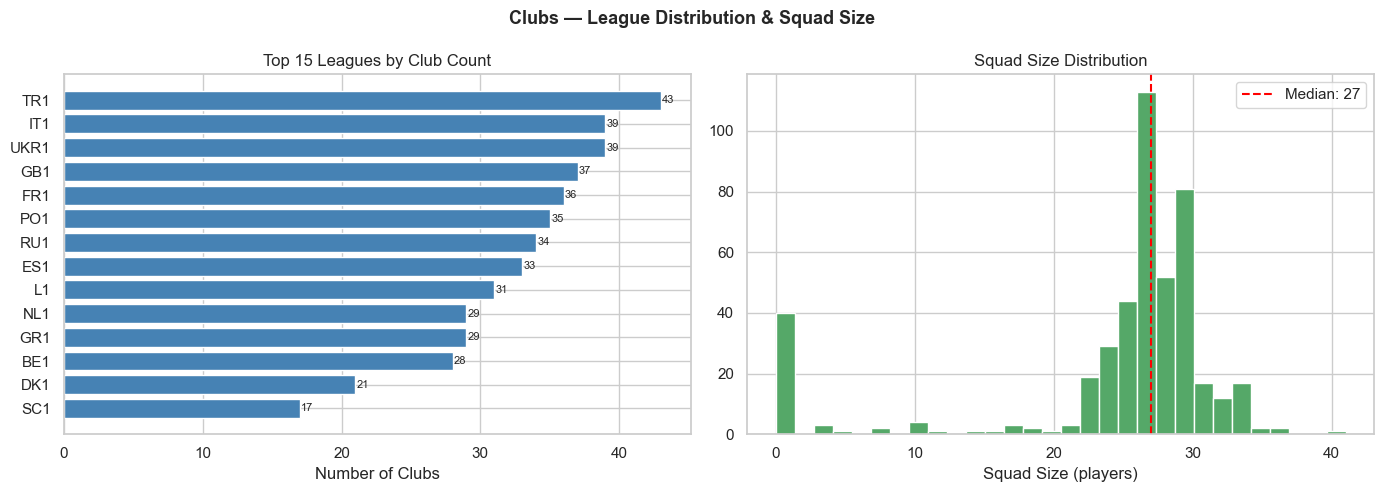


Unique leagues: 14
Squad size: min=0, median=27, max=41


In [13]:
# clubs.csv EDA
print(f'Clubs shape: {clubs.shape}')
print(f'Columns: {clubs.columns.tolist()}\n')

missing_clubs = clubs.isnull().sum()
missing_clubs = missing_clubs[missing_clubs > 0].sort_values(ascending=False)
print(f'Missing values:\n{missing_clubs.to_string()}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top leagues by club count
top_comps = clubs['domestic_competition_id'].value_counts().head(15)
axes[0].barh(top_comps.index[::-1], top_comps.values[::-1], color='steelblue')
axes[0].set_title('Top 15 Leagues by Club Count')
axes[0].set_xlabel('Number of Clubs')
for i, (idx, val) in enumerate(zip(top_comps.index[::-1], top_comps.values[::-1])):
    axes[0].text(val + 0.1, i, str(val), va='center', fontsize=8)

# Squad size distribution
sq = clubs['squad_size'].dropna()
axes[1].hist(sq, bins=30, color='#55A868', edgecolor='white')
axes[1].set_title('Squad Size Distribution')
axes[1].set_xlabel('Squad Size (players)')
axes[1].axvline(sq.median(), color='red', linestyle='--', label=f'Median: {sq.median():.0f}')
axes[1].legend()

plt.suptitle('Clubs — League Distribution & Squad Size', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_clubs_eda.png')
plt.show()

print(f'\nUnique leagues: {clubs["domestic_competition_id"].nunique()}')
print(f'Squad size: min={sq.min():.0f}, median={sq.median():.0f}, max={sq.max():.0f}')

## 10. Transfers — Transfer History per Player

Transfer fee — missing: 29,354  |  free (0): 45,349  |  paid (>0): 10,590

Transfers per player — median: 7,  max: 35


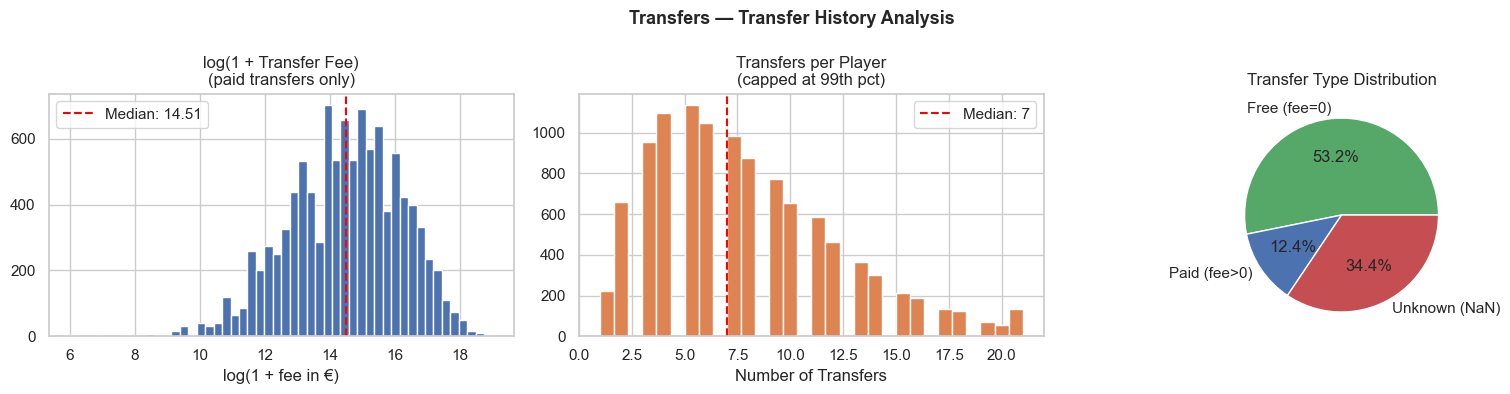

In [14]:
# transfers.csv EDA
transfers['transfer_fee'] = pd.to_numeric(transfers['transfer_fee'], errors='coerce')
fee = transfers['transfer_fee']

n_missing = fee.isna().sum()
n_zero    = (fee == 0).sum()
n_paid    = (fee > 0).sum()
print(f'Transfer fee — missing: {n_missing:,}  |  free (0): {n_zero:,}  |  paid (>0): {n_paid:,}')

# Transfers per player
trans_per_player = transfers.groupby('player_id').size()
print(f'\nTransfers per player — median: {trans_per_player.median():.0f},  max: {trans_per_player.max()}')

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# log(1+fee) for paid transfers
paid = fee[fee > 0].dropna()
axes[0].hist(np.log1p(paid), bins=50, color='#4C72B0', edgecolor='white')
axes[0].set_title('log(1 + Transfer Fee)\n(paid transfers only)')
axes[0].set_xlabel('log(1 + fee in €)')
axes[0].axvline(np.log1p(paid).median(), color='red', linestyle='--',
                label=f'Median: {np.log1p(paid).median():.2f}')
axes[0].legend()

# Transfers per player
cap99 = trans_per_player.quantile(0.99)
axes[1].hist(trans_per_player.clip(upper=cap99), bins=30, color='#DD8452', edgecolor='white')
axes[1].set_title('Transfers per Player\n(capped at 99th pct)')
axes[1].set_xlabel('Number of Transfers')
axes[1].axvline(trans_per_player.median(), color='red', linestyle='--',
                label=f'Median: {trans_per_player.median():.0f}')
axes[1].legend()

# Free vs paid vs unknown
labels = ['Free (fee=0)', 'Paid (fee>0)', 'Unknown (NaN)']
sizes  = [n_zero, n_paid, n_missing]
colors = ['#55A868', '#4C72B0', '#C44E52']
axes[2].pie([s for s in sizes if s > 0],
            labels=[l for l, s in zip(labels, sizes) if s > 0],
            autopct='%1.1f%%', colors=colors)
axes[2].set_title('Transfer Type Distribution')

plt.suptitle('Transfers — Transfer History Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '02_transfers_eda.png')
plt.show()

## Summary — Key Findings

### Target Variable
- `market_value_in_eur` is **heavily right-skewed** (median €0.2M, mean >>€2M) → **log transformation required** for modelling
- In 2024, the mean spiked to €3.7M due to inflation of top player valuations — the median remains consistently low

### Missing Values
- `agent_name` (~48%) and `contract_expiration_date` (~36%) → **dropped** from modelling
- `market_value_in_eur`, `height_in_cm`, `foot`, `country_of_birth` have ~7–9% missing → will be handled in notebook 03
- `date_of_birth` is almost fully present — safe to use for age computation

### Player Demographics
- Balanced dataset: Defender 10,893 / Midfield 9,903 / Attack 9,400 / Goalkeeper 3,906
- Age peaks at 27–29 years, mean 28.5
- **Height issue**: values below 100cm exist and are clearly erroneous → will be filtered in notebook 03
- Foot preference: 70% right, 25% left, 4.6% both

### Performance Stats
- All stats (goals, assists, minutes) are **heavily skewed** — median goals: 1, median appearances: 30
- Red cards have median 0 — near-zero informational value for most players

### Correlations
- **Strongest**: `total_assists` (0.29), `total_goals` (0.28), `total_appearances` (0.26), `total_minutes` (0.25)
- **Negative**: `age` (-0.22) — younger players tend to have higher market values
- **Negligible**: `height_in_cm` (~0.02) — height has no meaningful impact on market value

### Outliers
- Extreme values detected: ~480 goals, ~250 assists, ~48,000 minutes, ~600 appearances
- **Capping at the 99th percentile** will be applied in notebook 03

### Market Value by Position
- Attack > Midfield = Defender > Goalkeeper (medians: €0.28M / €0.25M / €0.25M / €0.15M)
- Large outliers exist in every position — justifies **training separate models per position**